# Nurse Rostering Problem Tutorial
## Using OR-Tools CP-SAT Solver

In this tutorial, we'll explore how to solve the Nurse Rostering Problem using Google's OR-Tools and the CP-SAT solver. The Nurse Rostering Problem is a classic scheduling problem where we need to assign nurses to shifts while respecting various constraints.

We'll cover:
1. Setting up the problem
2. Implementing basic constraints
3. Adding more complex constraints
4. Handling nurse preferences
5. Solving the problem and analyzing solutions
6. Variations of the problem

## 1. Introduction and Setup

Let's start by importing the necessary libraries and defining our initial problem parameters.

In [1]:
# Import required libraries
from ortools.sat.python import cp_model
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Define constants that will be used throughout the notebook
shift_names = ["Morning", "Evening", "Night"]

## 2. Problem Definition

The Nurse Rostering Problem involves assigning nurses to shifts over a planning horizon (e.g., a week) while respecting various constraints:

- Each shift must be covered by exactly one nurse
- Nurses cannot work more than one shift per day
- Shifts should be distributed fairly among nurses
- Nurses' preferences for certain shifts should be respected when possible
- Nurses' requests for days off should be respected when possible

Let's define our basic problem parameters:

In [2]:
# Problem parameters
num_nurses = 7  # Number of nurses
num_shifts = 3  # Number of shifts per day (Morning, Evening, Night)
num_days = 10    # Planning horizon

# Define ranges for convenience
all_nurses = range(num_nurses)
all_shifts = range(num_shifts)
all_days = range(num_days)

# Display problem parameters
print(f"Problem size: {num_nurses} nurses, {num_shifts} shifts per day, {num_days} days")
print(f"Total shifts to assign: {num_shifts * num_days}")
print(f"Minimum shifts per nurse: {(num_shifts * num_days) // num_nurses}")
print(f"Maximum shifts per nurse: {(num_shifts * num_days) // num_nurses + (1 if (num_shifts * num_days) % num_nurses != 0 else 0)}")

Problem size: 7 nurses, 3 shifts per day, 10 days
Total shifts to assign: 30
Minimum shifts per nurse: 4
Maximum shifts per nurse: 5


## 3. Modeling with CP-SAT

We'll now set up our constraint programming model using OR-Tools' CP-SAT solver. First, let's create the model and define our decision variables.

In [3]:
def create_basic_model():
    """Create a basic model with essential constraints but no preferences."""
    
    # Create the model
    model = cp_model.CpModel()
    
    # Create shift variables
    # shifts[(n, d, s)] = 1 if nurse n works shift s on day d, 0 otherwise
    shifts = {}
    for n in all_nurses:
        for d in all_days:
            for s in all_shifts:
                shifts[(n, d, s)] = model.new_bool_var(f"shift_n{n}_d{d}_s{s}")
    
    # Add essential constraints
    
    # Constraint 1: Each shift is assigned to exactly one nurse
    for d in all_days:
        for s in all_shifts:
            model.add_exactly_one(shifts[(n, d, s)] for n in all_nurses)
    
    # Constraint 2: Each nurse works at most one shift per day
    for n in all_nurses:
        for d in all_days:
            model.add_at_most_one(shifts[(n, d, s)] for s in all_shifts)
    
    # Constraint 3: Fair distribution of shifts
    min_shifts_per_nurse = (num_shifts * num_days) // num_nurses
    max_shifts_per_nurse = min_shifts_per_nurse + (1 if (num_shifts * num_days) % num_nurses != 0 else 0)
    
    for n in all_nurses:
        num_shifts_worked = sum(shifts[(n, d, s)] for d in all_days for s in all_shifts)
        model.add(min_shifts_per_nurse <= num_shifts_worked)
        model.add(num_shifts_worked <= max_shifts_per_nurse)
    
    return model, shifts

# Create the basic model
basic_model, basic_shifts = create_basic_model()
print("Basic model created with essential constraints.")

Basic model created with essential constraints.


### Understanding the Constraints

Let's break down the constraints implemented in the model above:

1. **Each shift must be covered by exactly one nurse**
   - For each day and shift, we require that exactly one nurse is assigned.
   - This is implemented using `model.add_exactly_one()`.

2. **Each nurse works at most one shift per day**
   - For each nurse and day, we ensure they're assigned to at most one shift.
   - This is implemented using `model.add_at_most_one()`.

3. **Fair distribution of shifts**
   - We ensure that the total number of shifts per nurse is within a specified range.
   - The minimum is the floor of the average (total shifts / number of nurses).
   - The maximum is the ceiling of the average.
   - For example, with 21 total shifts and 5 nurses, each nurse should work 4-5 shifts.

## 4. Adding Nurse Preferences

Now let's enhance our model by adding nurse preferences. We'll add:
1. Shift preferences (nurses requesting specific shifts)
2. Day-off requests

First, let's define the preference data:

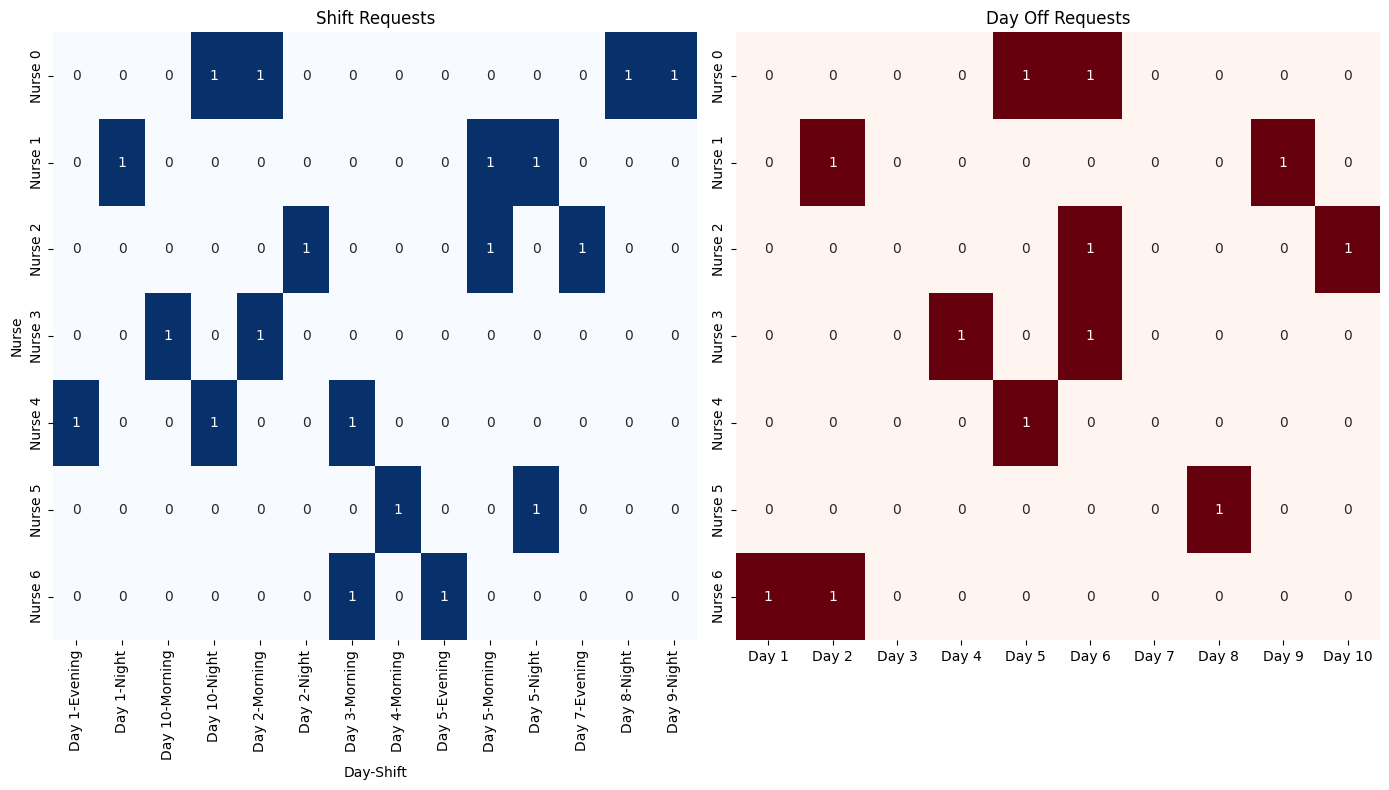

In [4]:
def generate_nurse_preference_matrices(num_nurses, num_days, num_shifts=3):
    """
    Generate random matrices for nurse scheduling preferences.
    
    Parameters:
    - num_nurses: Number of nurses
    - num_days: Number of days in the scheduling period
    - num_shifts: Number of shifts per day (default: 3, representing morning, evening, and night shifts)
    
    Returns:
    - shift_requests: 3D array [nurse][day][shift] = 1 if nurse requests that shift
    - day_off_requests: 2D array [nurse][day] = 1 if nurse requests that day off
    """
    # Initialize matrices with zeros
    shift_requests = [[[0 for _ in range(num_shifts)] for _ in range(num_days)] for _ in range(num_nurses)]
    day_off_requests = [[0 for _ in range(num_days)] for _ in range(num_nurses)]
    
    # Generate shift requests
    # Each nurse will request 2-4 specific shifts per week
    for n in range(num_nurses):
        # Determine how many shift requests this nurse will make
        num_shift_requests = random.randint(2, 4)
        
        # Randomly assign shift requests
        for _ in range(num_shift_requests):
            day = random.randint(0, num_days - 1)
            shift = random.randint(0, num_shifts - 1)
            shift_requests[n][day][shift] = 1
    
    # Generate day off requests
    # Each nurse will request 1-2 days off per period
    for n in range(num_nurses):
        # Determine how many days off this nurse will request
        num_days_off = random.randint(1, 2)
        
        # Randomly assign day off requests
        days_assigned = 0
        while days_assigned < num_days_off:
            day = random.randint(0, num_days - 1)
            # Only assign if not already assigned
            if day_off_requests[n][day] == 0 and shift_requests[n][day].count(1) == 0:
                day_off_requests[n][day] = 1
                days_assigned += 1
    
    return shift_requests, day_off_requests

shift_requests, day_off_requests = generate_nurse_preference_matrices(num_nurses=num_nurses, num_days=num_days)

# Visualize shift requests
def visualize_requests():
    plt.figure(figsize=(14, 8))
    
    plt.subplot(1, 2, 1)
    shift_data = []
    for n in all_nurses:
        for d in all_days:
            for s in all_shifts:
                if shift_requests[n][d][s] == 1:
                    shift_data.append((f"Nurse {n}", f"Day {d+1}", shift_names[s]))
    
    if shift_data:
        df = pd.DataFrame(shift_data, columns=["Nurse", "Day", "Shift"])
        table = pd.crosstab(df["Nurse"], [df["Day"], df["Shift"]])
        sns.heatmap(table, cmap="Blues", cbar=False, annot=True, fmt="d")
        plt.title("Shift Requests")
    else:
        plt.text(0.5, 0.5, "No shift requests", ha="center", va="center")
        plt.title("Shift Requests (None)")
    
    plt.subplot(1, 2, 2)
    day_off_df = pd.DataFrame(day_off_requests, 
                             index=[f"Nurse {n}" for n in all_nurses],
                             columns=[f"Day {d+1}" for d in all_days])
    sns.heatmap(day_off_df, cmap="Reds", cbar=False, annot=True, fmt=".0f")
    plt.title("Day Off Requests")
    
    plt.tight_layout()
    plt.show()

visualize_requests()

Now let's enhance our model to incorporate these preferences:

In [5]:
def create_model_with_preferences():
    """Create a model with both essential constraints and nurse preferences."""
    
    # Start with the basic model
    model, shifts = create_basic_model()
    
    # Add objective function to maximize the number of respected preferences
    model.maximize(
        # Reward for respecting shift requests
        sum(
            shift_requests[n][d][s] * shifts[(n, d, s)]
            for n in all_nurses
            for d in all_days
            for s in all_shifts
        )+
        # Reward for respecting day-off requests
        sum(
            # 1 - sum(...) is 1 when nurse n doesn't work any shift on day d
            (1 - sum(shifts[(n, d, s)] for s in all_shifts)) * day_off_requests[n][d]
            for n in all_nurses
            for d in all_days
        )
    )
    
    return model, shifts

# Create the model with preferences
model_with_preferences, shifts_with_preferences = create_model_with_preferences()
print("Model with preferences created.")

Model with preferences created.


### Understanding the Objective Function

The objective function aims to maximize the number of respected preferences. It consists of two parts:

1. **Shift requests**: We add 1 to the objective for each shift request that is respected.
   - If nurse n requested shift s on day d (`shift_requests[n][d][s] == 1`) and is assigned to that shift (`shifts[(n, d, s)] == 1`), we add 1 to the objective.

2. **Day-off requests**: We add 1 to the objective for each day-off request that is respected.
   - If nurse n requested day d off (`day_off_requests[n][d] == 1`) and is not assigned to any shift on that day (`sum(shifts[(n, d, s)] for s in all_shifts) == 0`), we add 1 to the objective.

## 5. Enhanced Constraints - Advanced Modeling

In real-world nurse rostering, we often have additional constraints. Let's explore some of these:

In [6]:
def create_advanced_model():
    """Create an advanced model with additional constraints."""
    
    # Start with the basic model with preferences
    model, shifts = create_model_with_preferences()
    
    # Additional Constraint 1: Consecutive Shifts
    # Nurses should not work night shift followed by morning shift the next day
    night_shift = 2  # Index for night shift
    morning_shift = 0  # Index for morning shift
    
    for n in all_nurses:
        for d in range(num_days - 1):  # All days except the last
            # If nurse n works night shift on day d, they cannot work morning shift on day d+1
            model.add(shifts[(n, d, night_shift)] + shifts[(n, d + 1, morning_shift)] <= 1)
    
    # Additional Constraint 2: Skill Requirements
    # Let's assume nurses 0 and 2 are senior and at least one senior nurse must be present each day
    senior_nurses = [0, 2]
    
    for d in all_days:
        # At least one senior nurse must work on day d (any shift)
        model.add(
            sum(shifts[(n, d, s)] for n in senior_nurses for s in all_shifts) >= 1
        )
    
    # Additional Constraint 3: Consecutive Work Days
    # Nurses should not work more than 3 consecutive days
    max_consecutive_days = 3
    
    for n in all_nurses:
        for d in range(num_days - max_consecutive_days + 1):
            # Calculate if nurse n works on each of the consecutive days
            works_on_days = [
                shifts[(n, d + i, s)] for i in range(max_consecutive_days) for s in all_shifts
            ]
            # Ensure at least one day off after max_consecutive_days
            model.add(sum(works_on_days) <= max_consecutive_days)
    
    return model, shifts

# Create the advanced model
advanced_model, advanced_shifts = create_advanced_model()
print("Advanced model created with additional constraints.")

Advanced model created with additional constraints.


### Understanding the Advanced Constraints

Let's break down the additional constraints we've added:

1. **Consecutive Shifts**
   - Nurses should not work a night shift followed by a morning shift the next day.
   - This is a common constraint in nurse rostering to ensure adequate rest between shifts.
   - We enforce this by adding `shifts[(n, d, night_shift)] + shifts[(n, d + 1, morning_shift)] <= 1` for each nurse and day.

2. **Skill Requirements**
   - Some shifts may require nurses with specific skills or seniority.
   - In our example, we assume nurses 0 and 2 are senior, and we require at least one senior nurse to be present each day.
   - We enforce this by adding `sum(shifts[(n, d, s)] for n in senior_nurses for s in all_shifts) >= 1` for each day.

3. **Consecutive Work Days**
   - Nurses should not work too many consecutive days without a break.
   - In our example, we limit to 3 consecutive working days.
   - We enforce this by adding constraints to ensure that for any sequence of 4 consecutive days, at least one is a day off.

## 6. Solving the Problem

Now let's implement the solution printer to display the results. We'll use the same solution printer from the original code but add some visualizations.

In [11]:
class SolutionPrinter(cp_model.CpSolverSolutionCallback):
    def __init__(self, shifts, num_nurses, num_days, num_shifts, shift_requests=None, day_off_requests=None):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self._shifts = shifts
        self._num_nurses = num_nurses
        self._num_days = num_days
        self._num_shifts = num_shifts
        self._solution_count = 0
        self._best_objective = float('-inf')
        self._best_solutions = []
        self._shift_requests = shift_requests
        self._day_off_requests = day_off_requests

    def on_solution_callback(self):
        self._solution_count += 1
        current_objective = self.ObjectiveValue()

        # If this is a better solution, reset best solutions list
        if current_objective > self._best_objective:
            self._best_objective = current_objective
            self._best_solutions = [self.extract_solution()]
        elif current_objective == self._best_objective:
            self._best_solutions.append(self.extract_solution())

    def extract_solution(self):
        """Extracts the solution as a structured format."""
        solution = []
        for d in range(self._num_days):
            day_schedule = []
            for n in range(self._num_nurses):
                shifts_worked = []
                for s in range(self._num_shifts):
                    if self.value(self._shifts[(n, d, s)]):
                        shifts_worked.append(shift_names[s])
                day_schedule.append((n, shifts_worked))
            solution.append(day_schedule)
        return solution

    def print_best_solutions(self):
        print(f"\nBest Objective Value: {self._best_objective}")
        print(f"Total optimal solutions found: {len(self._best_solutions)}")

        total_requests = 0
        if self._shift_requests and self._day_off_requests:
            total_requests = sum(sum(sum(day) for day in nurse) for nurse in self._shift_requests) + \
                          sum(sum(day) for day in self._day_off_requests)

        for i, sol in enumerate(self._best_solutions[:1]):  # Print only the first solution for brevity
            print(f"\nOptimal Solution {i + 1}:")
            respected_requests = 0

            for d, day_schedule in enumerate(sol):
                print(f"Day {d + 1}:")
                for nurse, shifts in day_schedule:
                    shift_str = ', '.join(shifts) if shifts else "No shift"
                    requested = False
                    
                    if self._shift_requests and self._day_off_requests:
                        if not shifts and self._day_off_requests[nurse][d] == 1:
                            requested = True
                            respected_requests += 1
                        elif shifts and any(self._shift_requests[nurse][d][s] == 1 
                                     for s in range(self._num_shifts) 
                                     if shift_names[s] in shifts):
                            requested = True
                            respected_requests += 1
                        
                    print(f"  Nurse {nurse}: {shift_str} {'(requested)' if requested else ''}")
                print()
                
            if total_requests > 0:
                print(f"Total respected requests: {respected_requests} / {total_requests}")
                
        return self._best_solutions[0] if self._best_solutions else None

    def visualize_solution(self, solution_index=0, preferences=True):
        """Visualize the solution using a heatmap."""
        if not self._best_solutions:
            print("No solutions to visualize.")
            return
            
        solution = self._best_solutions[solution_index]
        
        # Create a matrix to represent the schedule
        schedule_matrix = [['' for _ in range(self._num_days)] for _ in range(self._num_nurses)]
        
        for d, day_schedule in enumerate(solution):
            for nurse, shifts in day_schedule:
                if shifts:
                    schedule_matrix[nurse][d] = shifts[0][0]  # First letter of shift
                else:
                    schedule_matrix[nurse][d] = '-'  # No shift
        
        # Convert to DataFrame for easier visualization
        df = pd.DataFrame(schedule_matrix, 
                        index=[f"Nurse {n}" for n in range(self._num_nurses)],
                        columns=[f"Day {d+1}" for d in range(self._num_days)])
        
        # Create a numerical mapping for the shifts
        shift_to_num = {'M': 0, 'E': 1, 'N': 2, '-': 3}
        df_numeric = df.applymap(lambda x: shift_to_num.get(x, 3))
        
        # Define colors for each shift type
        basic_colors = {'M': '#8dd3c7', 'E': '#2F81D0', 'N': '#bebada', '-': '#f0f0f0'}
        colors = ['#f0f0f0', '#f0f0f0', '#f0f0f0', '#f0f0f0']
        cmap = ListedColormap(colors)
        
        # Plot the heatmap
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(df_numeric, cmap=cmap, cbar=False, linewidths=.5)
        plt.title(f"Optimal Schedule (Objective Value: {self._best_objective})")

        # Loop over the DataFrame to add annotations with conditional colors
        for i in range(df_numeric.shape[0]):       # iterate over nurses (rows)
            for j in range(df_numeric.shape[1]):   # iterate over days (columns)
                # Get the letter for the current cell
                letter = df.iloc[i, j]
                if not preferences:
                    cell_color = basic_colors.get(letter, '#f0f0f0')
                else:
                    # Determine the color based on the conditions:
                    if day_off_requests[i][j] == 1:
                        if letter == '-':
                            cell_color = 'green'
                        else:
                            cell_color = 'orange'
                    else:
                        # Map letter to its shift index (M=0, E=1, N=2)
                        if letter == 'M':
                            shift_index = 0
                        elif letter == 'E':
                            shift_index = 1
                        elif letter == 'N':
                            shift_index = 2
                        else:
                            shift_index = None
                        
                        if shift_requests[i][j]==[0,0,0]:
                            cell_color = 'grey'
                        elif shift_index is None:
                            cell_color = 'orange'
                        # If the nurse requested the assigned shift, set the cell to green.
                        elif shift_requests[i][j][shift_index] == 1:
                            cell_color = 'green'
                        else:
                            cell_color = 'orange'
                
                # Create and add a rectangle patch for the cell.
                # Note: The heatmap grid coordinates start at (0,0) at the top left.
                rect = plt.Rectangle((j, i), 1, 1, facecolor=cell_color,
                                    edgecolor='white', lw=0.5, alpha=0.6)
                ax.add_patch(rect)
                
                # Optionally, overlay the shift letter on top of the colored cell.
                # Here, we choose white text for better contrast on dark backgrounds.
                ax.text(j + 0.5, i + 0.5, letter, ha='center', va='center', color='white')

        plt.show()

    def solution_count(self):
        return self._solution_count

Now let's solve our models and compare the results:

In [8]:
def solve_model(model, shifts, model_name, with_preferences=False):
    """Solve the model and print/visualize the solution."""
    print(f"\n=== Solving {model_name} ===\n")
    
    # Create the solver
    solver = cp_model.CpSolver()
    
    # Create the solution printer
    if with_preferences:
        solver.parameters.enumerate_all_solutions = True
        solution_printer = SolutionPrinter(shifts, num_nurses, num_days, num_shifts, 
                                          shift_requests, day_off_requests)
    else:
        solution_printer = SolutionPrinter(shifts, num_nurses, num_days, num_shifts)
    
    # Solve the model
    status = solver.solve(model, solution_printer)
    
    # Print status
    print(f"Solver status: {solver.StatusName(status)}")
    
    # Print solution details
    solution = solution_printer.print_best_solutions()
    
    # Visualize the solution
    solution_printer.visualize_solution(preferences=with_preferences)
    
    # Print statistics
    print("\nStatistics")
    print(f"  - Conflicts: {solver.num_conflicts}")
    print(f"  - Branches : {solver.num_branches}")
    print(f"  - Wall time: {solver.wall_time} seconds")
    print(f"  - Solutions: {solution_printer.solution_count()}")


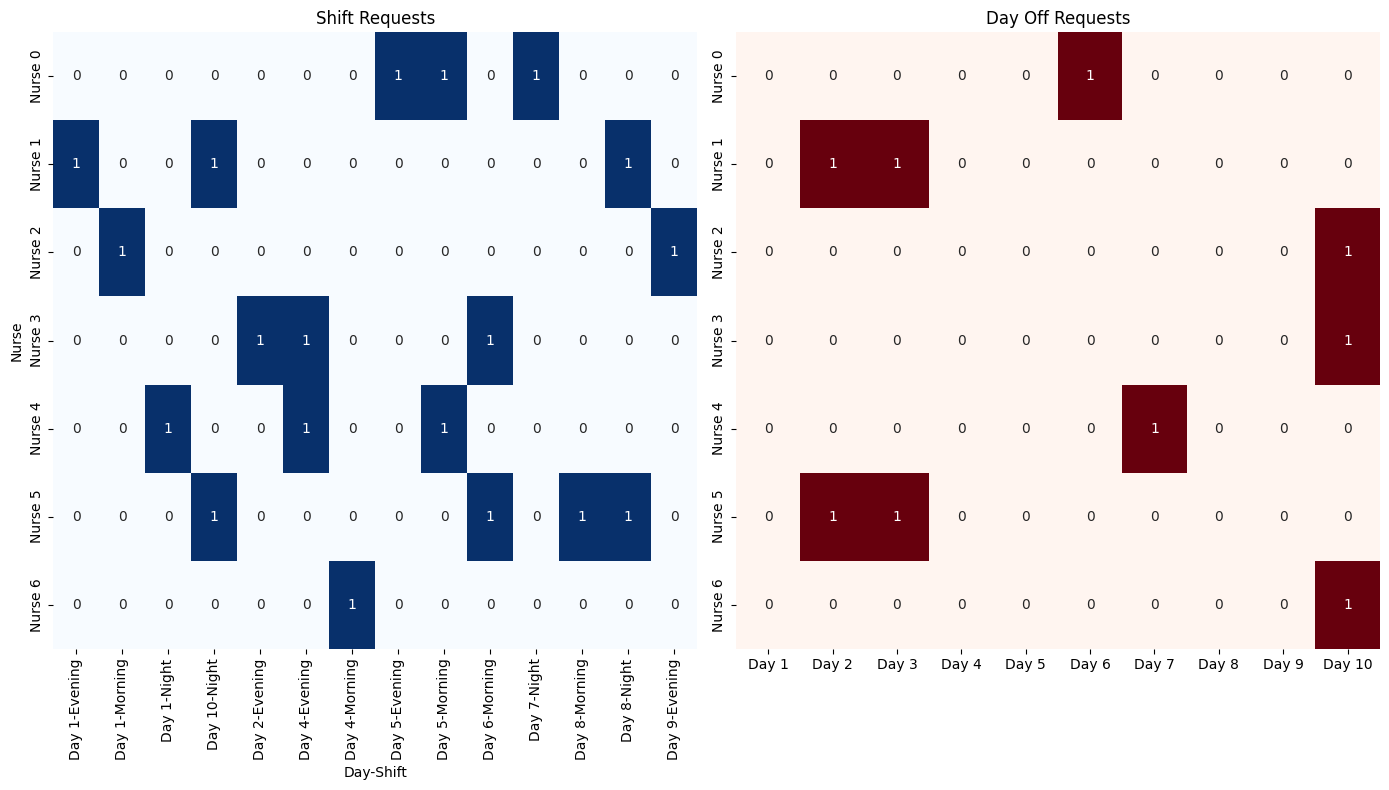


=== Solving Advanced Model ===

Solver status: OPTIMAL

Best Objective Value: 23.0
Total optimal solutions found: 1

Optimal Solution 1:
Day 1:
  Nurse 0: No shift 
  Nurse 1: Evening (requested)
  Nurse 2: Morning (requested)
  Nurse 3: No shift 
  Nurse 4: Night (requested)
  Nurse 5: No shift 
  Nurse 6: No shift 

Day 2:
  Nurse 0: Morning 
  Nurse 1: No shift (requested)
  Nurse 2: No shift 
  Nurse 3: Evening (requested)
  Nurse 4: No shift 
  Nurse 5: No shift (requested)
  Nurse 6: Night 

Day 3:
  Nurse 0: No shift 
  Nurse 1: No shift (requested)
  Nurse 2: Morning 
  Nurse 3: Night 
  Nurse 4: Evening 
  Nurse 5: No shift (requested)
  Nurse 6: No shift 

Day 4:
  Nurse 0: No shift 
  Nurse 1: No shift 
  Nurse 2: Night 
  Nurse 3: Evening (requested)
  Nurse 4: No shift 
  Nurse 5: No shift 
  Nurse 6: Morning (requested)

Day 5:
  Nurse 0: Evening (requested)
  Nurse 1: Night 
  Nurse 2: No shift 
  Nurse 3: No shift 
  Nurse 4: Morning (requested)
  Nurse 5: No shift 
  

/var/folders/0j/8skb_l2j2ms5bcd5v4zdm3fw0000gn/T/ipykernel_57041/3813664404.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = df.applymap(lambda x: shift_to_num.get(x, 3))


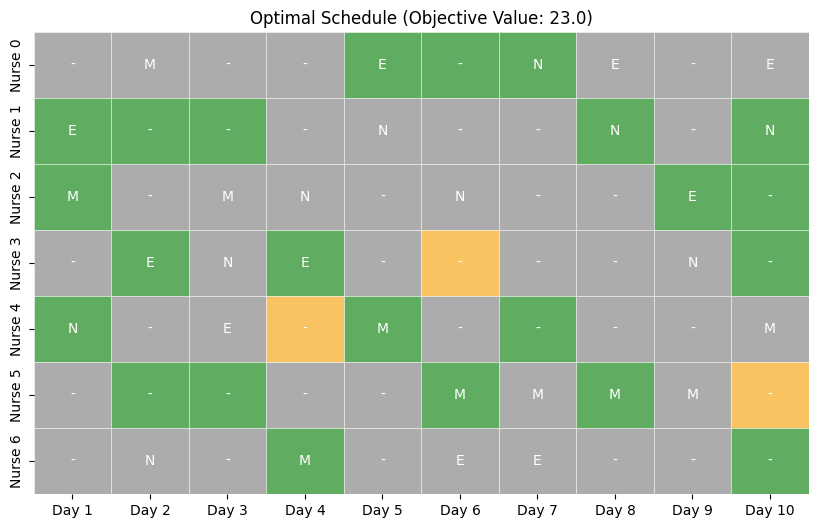


Statistics
  - Conflicts: 51
  - Branches : 1613
  - Wall time: 0.061957000000000005 seconds
  - Solutions: 2


In [30]:
#Regenerate random preferences for nurses and visualize them
shift_requests, day_off_requests = generate_nurse_preference_matrices(num_nurses=num_nurses, num_days=num_days)
visualize_requests()

# Solve the basic model
#basic_model, basic_shifts = create_basic_model()
#solve_model(basic_model, basic_shifts, "Basic Model")

# Solve the model with preferences
#model_with_preferences, shifts_with_preferences = create_model_with_preferences()
#solve_model(model_with_preferences, shifts_with_preferences, "Model with Preferences", with_preferences=True)

# Solve the advanced model
advanced_model, advanced_shifts = create_advanced_model()
solve_model(advanced_model, advanced_shifts, "Advanced Model", with_preferences=True)